<a href="https://colab.research.google.com/github/Mehrdad93/Trajectory-path-prediction/blob/master/GRU_trj_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import glob
from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [0]:
df = pd.read_csv('input_trj.csv', header=0)
df

,TimeStep,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,1,145.713,1.28677,147.598000,146.015,0.873319,148.847000,147.269,1.086830,149.442000,148.242000,1.75741,148.655000,147.911,2.21957,147.348000,146.625,1.99104,146.793000,144.059,0.025532,148.313000,144.478,0.786622,147.260000,144.973,0.120288,149.325000,143.707,0.834280,145.991000,144.793,149.41900,0.623450,142.921,149.07800,148.280,141.564,149.50300,148.400,...,147.19600,61.8216,1.95052,3.20215,61.7718,0.379876,2.41121,60.2862,1.31021,2.62934,60.6363,146.90700,149.48400,62.7548,149.46600,148.68100,62.7402,147.91700,149.51000,62.8944,149.39500,0.441961,58.6806,2.36412,0.736561,57.1371,1.57192,0.636658,57.9232,2.12774,149.16300,57.3204,146.55200,148.75000,57.3443,146.42600,0.512548,58.6381,145.71600,149.55900
1,2,145.713,1.28343,147.596000,146.013,0.870038,148.845000,147.266,1.086040,149.443000,148.241000,1.75464,148.656000,147.913,2.21319,147.348000,146.627,1.98539,146.791000,144.059,0.020241,148.309000,144.478,0.783386,147.256000,144.974,0.112622,149.320000,143.708,0.831600,145.987000,144.791,149.40900,0.616462,142.918,149.07500,148.278,141.561,149.50000,148.392,...,147.20000,61.8114,1.95922,3.20384,61.7737,0.387761,2.41349,60.2813,1.30865,2.62766,60.6332,146.91100,149.49000,62.7563,149.52600,148.71300,62.7323,147.92900,149.43800,62.8889,149.34300,0.463898,58.6734,2.36938,0.737992,57.1295,1.58018,0.623539,57.9288,2.13710,149.15900,57.3158,146.56100,148.74900,57.3396,146.43100,0.511070,58.6329,145.72200,149.55600
2,3,145.715,1.26723,147.592000,146.014,0.854621,148.843000,147.267,1.072040,149.441000,148.240000,1.74586,148.657000,147.911,2.20875,147.350000,146.627,1.97624,146.791000,144.059,0.008061,148.305000,144.481,0.767516,147.251000,144.970,0.104574,149.319000,143.708,0.820159,145.984000,144.770,149.42000,0.622949,142.918,149.06300,148.271,141.563,149.49500,148.376,...,147.20400,61.7926,1.97697,3.20285,61.7736,0.402071,2.41876,60.2726,1.31102,2.62020,60.6249,146.92000,149.48100,62.7648,149.59500,148.76700,62.7184,147.94700,149.36500,62.8708,149.27600,0.502368,58.6608,2.37197,0.749525,57.1139,1.59175,0.602388,57.9408,2.15703,149.15600,57.3066,146.56400,148.75200,57.3333,146.44300,0.514995,58.6246,145.72800,149.56200
3,4,145.722,1.24994,147.586000,146.014,0.839538,148.839000,147.264,1.057240,149.442000,148.243000,1.72698,148.659000,147.918,2.18806,147.350000,146.637,1.95678,146.787000,144.061,-0.004076,148.291000,144.491,0.750403,147.238000,144.963,0.093676,149.311000,143.728,0.796193,145.964000,144.745,149.41100,0.613711,142.919,149.05600,148.250,141.565,149.49200,148.359,...,147.20000,61.7705,1.99583,3.19797,61.7699,0.420343,2.41400,60.2592,1.31577,2.60675,60.6186,146.93300,149.48300,62.7706,149.63400,148.79800,62.7098,147.96400,149.32900,62.8600,149.24600,0.519931,58.6483,2.37342,0.771041,57.0995,1.60894,0.572370,57.9668,2.18994,149.15700,57.2988,146.58000,148.74900,57.3240,146.46000,0.511872,58.6159,145.74500,149.56000
4,5,145.735,1.23429,147.568000,146.013,0.830846,148.827000,147.260,1.041000,149.439000,148.250000,1.69669,148.661000,147.943,2.14782,147.344000,146.664,1.92353,146.771000,144.064,-0.014023,148.265000,144.505,0.735272,147.213000,144.960,0.084770,149.290000,143.758,0.768563,145.928000,144.745,149.38500,0.583480,142.920,149.04800,148.227,141.568,149.48600,148.346,...,147.19300,61.7576,2.01922,3.18942,61.7676,0.441365,2.40903,60.2515,1.33079,2.59434,60.6173,146.94900,149.48400,62.7607,149.63500,148.77400,62.7084,147.98000,149.34700,62.8592,149.29100,0.504025,58.6255,2.36758,0.803929,57.0778,1.62934,0.513486,58.0185,2.22984,149.15600,57.3035,146.59400,148.74200,57.3224,146.47100,0.504751,58.6192,145.75900,149.55700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

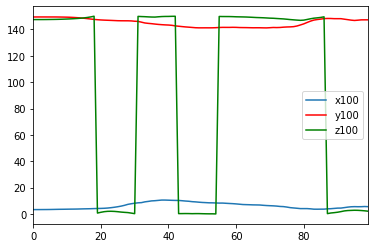

In [0]:
ax = plt.gca()
df.plot(kind='line', y='x100', ax=ax)
df.plot(kind='line', y='y100', color='red', ax=ax)
df.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

In [0]:
# Data generation

import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

def SMOTE(T, N, k):
  """
  Returns (N/100) * n_minority_samples synthetic minority samples.

  Parameters
  ----------
  T : array-like, shape = [n_minority_samples, n_features]
      Holds the minority samples
  N : percetange of new synthetic samples: 
      n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
  k : int. Number of nearest neighbours. 

  Returns
  -------
  S : array, shape = [(N/100) * n_minority_samples, n_features]
  """    
  n_minority_samples, n_features = T.shape

  if N < 100:
      #create synthetic samples only for a subset of T.
      #TODO: select random minortiy samples
      N = 100
      pass

  if (N % 100) != 0:
      raise ValueError("N must be < 100 or multiple of 100")

  N = int(N/100)
  n_synthetic_samples = int(N * n_minority_samples)
  S = np.zeros(shape=(n_synthetic_samples, n_features))

  #Learn nearest neighbours
  neigh = NearestNeighbors(n_neighbors = k)
  neigh.fit(T)

  #Calculate synthetic samples
  for i in range(n_minority_samples):
      nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
      for n in range(N):
          nn_index = choice(nn[0])
          #NOTE: nn includes T[i], we don't want to select it 
          while nn_index == i:
              nn_index = choice(nn[0])

          dif = T[nn_index] - T[i]
          gap = np.random.random()
          S[n + i * N, :] = T[i,:] + gap * dif[:]

  return S

# n_minority_samples = len(df_0)
# n_features = len(df_0.columns)
# T shape: [n_minority_samples, n_features]
df_modified = df.iloc[:,1:] 
col = list(df_modified.columns) 
T = df_modified.to_numpy()
new_data = SMOTE(T, N = 1e4, k = 2)
new_data.shape

(10000, 1038)

In [0]:
df_new = pd.DataFrame(data = new_data,
                      index = [i for i in range(new_data.shape[0])],
                      columns = col)
df_new

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,145.713000,1.285550,147.597269,146.014269,0.872120,148.846269,147.267904,1.086541,149.442365,148.241635,1.756398,148.655365,147.911731,2.217239,147.348000,146.625731,1.988976,146.792269,144.059000,0.023599,148.311539,144.478000,0.785440,147.258539,144.973365,0.117487,149.323173,143.707365,0.833301,145.989539,144.792269,149.415347,0.620897,142.919904,149.076904,148.279269,141.562904,149.501904,148.397077,143.206539,...,147.197461,61.817874,1.953698,3.202767,61.772494,0.382757,2.412043,60.284410,1.309640,2.628726,60.635167,146.908461,149.486192,62.755348,149.487919,148.692690,62.737314,147.921384,149.483697,62.892391,149.376003,0.449975,58.677970,2.366042,0.737084,57.134324,1.574938,0.631865,57.925246,2.131159,149.161539,57.318720,146.555288,148.749635,57.342583,146.427827,0.512008,58.636200,145.718192,149.557904
1,145.713000,1.283595,147.596099,146.013099,0.870200,148.845099,147.266148,1.086079,149.442951,148.241049,1.754777,148.655951,147.912901,2.213505,147.348000,146.626901,1.985669,146.791099,144.059000,0.020502,148.309198,144.478000,0.783546,147.256198,144.973951,0.113001,149.320247,143.707951,0.831732,145.987198,144.791099,149.409494,0.616807,142.918148,149.075148,148.278099,141.561148,149.500148,148.392395,143.204198,...,147.199802,61.811904,1.958790,3.203757,61.773606,0.387372,2.413377,60.281542,1.308727,2.627743,60.633353,146.910802,149.489704,62.756226,149.523037,148.711420,62.732690,147.928407,149.441555,62.889172,149.345568,0.462815,58.673756,2.369120,0.737921,57.129875,1.579772,0.624187,57.928523,2.136638,149.159198,57.316027,146.560556,148.749049,57.339832,146.430753,0.511143,58.633157,145.721704,149.556148
2,145.713000,1.284170,147.596443,146.013443,0.870765,148.845443,147.266665,1.086215,149.442778,148.241222,1.755254,148.655778,147.912557,2.214604,147.348000,146.626557,1.986642,146.791443,144.059000,0.021413,148.309887,144.478000,0.784103,147.256887,144.973778,0.114321,149.321108,143.707778,0.832194,145.987887,144.791443,149.411216,0.618011,142.918665,149.075665,148.278443,141.561665,149.500665,148.393773,143.204887,...,147.199113,61.813661,1.957292,3.203465,61.773279,0.386013,2.412985,60.282386,1.308996,2.628032,60.633887,146.910113,149.488670,62.755968,149.512702,148.705908,62.734051,147.926340,149.453957,62.890119,149.354525,0.459036,58.674996,2.368214,0.737675,57.131184,1.578349,0.626447,57.927559,2.135026,149.159887,57.316819,146.559005,148.749222,57.340642,146.429892,0.511398,58.634052,145.720670,149.556665
3,145.713000,1.285773,147.597403,146.014403,0.872339,148.846403,147.268104,1.086594,149.442299,148.241701,1.756583,148.655299,147.911597,2.217665,147.348000,146.625597,1.989353,146.792403,144.059000,0.023952,148.311806,144.478000,0.785656,147.258806,144.973299,0.117999,149.323507,143.707299,0.833480,145.989806,144.792403,149.416014,0.621364,142.920104,149.077104,148.279403,141.563104,149.502104,148.397612,143.206806,...,147.197194,61.818555,1.953117,3.202655,61.772367,0.382230,2.411891,60.284737,1.309744,2.628838,60.635374,146.908194,149.485791,62.755248,149.483913,148.690554,62.737841,147.920583,149.488504,62.892758,149.379475,0.448510,58.678450,2.365690,0.736988,57.134831,1.574386,0.632741,57.924872,2.130534,149.161806,57.319027,146.554687,148.749701,57.342897,146.427493,0.512107,58.636548,145.717791,149.558104
4,145.713000,1.286447,147.597807,146.014807,0.873002,148.846807,147.268710,1.086754,149.442097,148.241903,1.757142,148.655097,147.911193,2.218953,147.348000,146.625193,1.990494,146.792807,144.059000,0.025020,148.312613,144.478000,0.786309,147.259613,144.973097,0.119547,149.324517,143.707097,0.834021,145.990613,144.792807,149.418033,0.622774,142.920710,149.0777

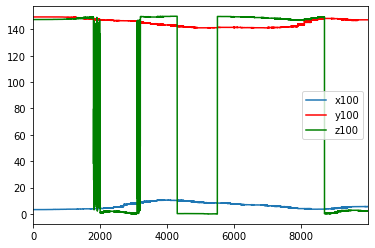

In [0]:
ax = plt.gca()
df_new.plot(kind='line', y='x100', ax=ax)
df_new.plot(kind='line', y='y100', color='red', ax=ax)
df_new.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

In [0]:
# Normalization (RobustScaler) (0,0.5)
transformer = Normalizer().fit(df_new)
# transformer = StandardScaler().fit(df_new)
array_norm = transformer.transform(df_new)*10
df_norm = pd.DataFrame(data = array_norm,
                      index = [i for i in range(new_data.shape[0])],
                      columns = col)

# Add timeStep column back
df_norm.insert(0, "TimeStep", range(1,len(df_norm)+1))
df_norm

,TimeStep,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,...,z333,x334,y334,z334,x335,y335,z335,x336,y336,z336,x337,y337,z337,x338,y338,z338,x339,y339,z339,x340,y340,z340,x341,y341,z341,x342,y342,z342,x343,y343,z343,x344,y344,z344,x345,y345,z345,x346,y346,z346
0,1,0.444701,0.003923,0.450451,0.445620,0.002662,0.454263,0.449446,0.003316,0.456082,0.452418,0.005360,0.453681,0.451411,0.006767,0.449691,0.447486,0.006070,0.447995,0.439653,0.000072,0.452631,0.440932,0.002397,0.449418,0.442444,0.000359,0.455719,0.438580,0.002543,0.445545,0.441891,0.456000,0.001895,0.436177,0.454967,0.452533,0.432035,0.456264,0.452892,...,0.449231,0.188662,0.005962,0.009775,0.188523,0.001168,0.007361,0.183982,0.003997,0.008023,0.185052,0.448349,0.456216,0.191523,0.456221,0.453795,0.191468,0.451441,0.456209,0.191941,0.455880,0.001373,0.179079,0.007221,0.002250,0.174368,0.004807,0.001928,0.176782,0.006504,0.455225,0.174931,0.447271,0.453968,0.175004,0.446882,0.001563,0.178952,0.444717,0.456435
1,2,0.444701,0.003917,0.450448,0.445617,0.002656,0.454260,0.449441,0.003315,0.456085,0.452417,0.005355,0.453683,0.451415,0.006755,0.449691,0.447490,0.006060,0.447992,0.439653,0.000063,0.452625,0.440932,0.002391,0.449411,0.442446,0.000345,0.455710,0.438582,0.002538,0.445538,0.441888,0.455983,0.001882,0.436172,0.454962,0.452530,0.432030,0.456259,0.452879,...,0.449239,0.188644,0.005978,0.009778,0.188527,0.001182,0.007365,0.183973,0.003994,0.008020,0.185047,0.448357,0.456227,0.191526,0.456329,0.453852,0.191454,0.451463,0.456081,0.191931,0.455788,0.001412,0.179066,0.007230,0.002252,0.174355,0.004821,0.001905,0.176792,0.006521,0.455219,0.174923,0.447288,0.453967,0.174995,0.446892,0.001560,0.178942,0.444728,0.456430
2,3,0.444701,0.003919,0.450449,0.445618,0.002657,0.454261,0.449443,0.003315,0.456084,0.452417,0.005357,0.453682,0.451414,0.006759,0.449691,0.447489,0.006063,0.447992,0.439653,0.000065,0.452627,0.440932,0.002393,0.449413,0.442445,0.000349,0.455713,0.438581,0.002540,0.445540,0.441889,0.455988,0.001886,0.436173,0.454964,0.452531,0.432032,0.456261,0.452883,...,0.449237,0.188649,0.005973,0.009777,0.188526,0.001178,0.007364,0.183976,0.003995,0.008020,0.185048,0.448355,0.456224,0.191525,0.456297,0.453835,0.191458,0.451456,0.456118,0.191934,0.455815,0.001401,0.179070,0.007228,0.002251,0.174359,0.004817,0.001912,0.176789,0.006516,0.455221,0.174925,0.447283,0.453967,0.174998,0.446889,0.001561,0.178945,0.444725,0.456432
3,4,0.444701,0.003924,0.450452,0.445621,0.002662,0.454264,0.449447,0.003316,0.456082,0.452418,0.005361,0.453680,0.451411,0.006768,0.449691,0.447486,0.006071,0.447995,0.439653,0.000073,0.452632,0.440932,0.002398,0.449418,0.442443,0.000360,0.455720,0.438580,0.002544,0.445546,0.441891,0.456002,0.001896,0.436177,0.454968,0.452533,0.432036,0.456265,0.452894,...,0.449230,0.188664,0.005961,0.009774,0.188523,0.001167,0.007361,0.183983,0.003997,0.008023,0.185053,0.448348,0.456215,0.191522,0.456209,0.453788,0.191469,0.451438,0.456223,0.191942,0.455890,0.001369,0.179080,0.007220,0.002249,0.174369,0.004805,0.001931,0.176781,0.006502,0.455226,0.174932,0.447269,0.453968,0.175004,0.446881,0.001563,0.178953,0.444715,0.456436
4,5,0.444701,0.003926,0.450453,0.445622,0.002664,0.454265,0.449448,0.003317,0.456081,0.452419,0.005363,0.453680,0.451409,0.006772,0.449690,0.447484,0.006075,0.447996,0.439653,0.000076,0.452634,0.440931,0.002400,0.449421,0.442442,0.000365,0.455723,0.438579,0.002545,0.445548,0.441892,0.456008,0.001901,0.436179,0.454969,0.452534,0.432037,0.456266,0.452899,...,0.449228,0.188670,0.005955,0.009773,0.188522,0.001162,0.007359,0.183986,0.003998,0.008024,0.185055,0.448346,0.456211,0.191521,0.456172,0.453768,0.191474,0.451430,0.456267,0.191945,0.455922,0.001355,0.179085,0.007217,0.002248,0.174374,0.004800,0.001939,0.176777,0.006496,0.455228,0.174934,0.447264,0.453969,0.175007,0.446878,0.001564,0.178956,0.444712,0.456437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

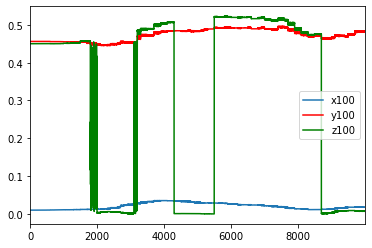

In [0]:
ax = plt.gca()
df_norm.plot(kind='line', y='x100', ax=ax)
df_norm.plot(kind='line', y='y100', color='red', ax=ax)
df_norm.plot(kind='line', y='z100', color='green', ax=ax)

plt.show()

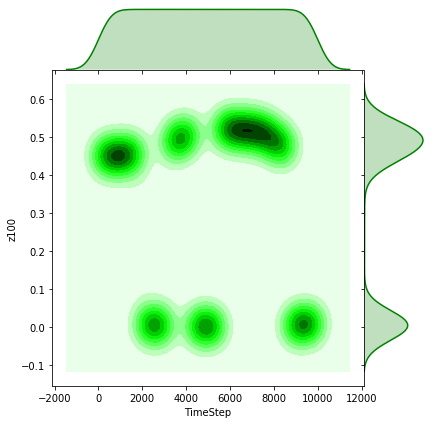

In [0]:
sns.jointplot("TimeStep", "z100", df_norm, kind="kde", space=0, color="g")

In [0]:
target = ['x100', 'y100', 'z100'] # Atom 100
shift_steps = 10         # number of steps to predict in the future
df_targets = df_norm[target].shift(-shift_steps)
n1 = df_norm.columns.get_loc("x100")

# 5+ and 5- of target atom
feature_col = df_norm.columns[n1-15:n1+18]
df_feature = df_norm[feature_col]
#
x_data = df_feature.values[0:-shift_steps]
y_data = df_targets.values[0:-shift_steps]  

num_data = len(x_data)  # data-points
train_split = 0.85       # fraction of the data-set for the training-set

num_train = int(train_split * num_data)
num_test = num_data - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

validation_data = (np.expand_dims(x_test, axis=0),
                   np.expand_dims(y_test, axis=0))
num_x_signals

33

In [0]:
# Instead of training the RNN on the complete sequences of 10000 observations, -
# we will use the following function to create a batch of shorter sub-sequences -
# picked at random from the training-data.

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data.
    """
    # Infinite loop
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float64)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float64)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

batch_size = 50  # 2^n like!
sequence_length = 200   
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

In [0]:
# Create the Recurrent Neural Network
model = Sequential()
model.add(GRU(units = 128,   
              return_sequences = True,
              input_shape = (None, num_x_signals,)))

# To predict 3 output-signals, we add a fully-connected (or dense) layer,
# which maps 512 values down to only 3 values.
model.add(Dense(num_y_signals, activation = 'sigmoid'))

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.02, maxval=0.02)  

    model.add(Dense(num_y_signals,
                    activation = 'linear',
                    kernel_initializer = init))
    

In [0]:
# Loss Function: MSE
warmup_steps = 10     # can be set to zero if no fluctuations at the beginning! 

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels = y_true_slice,
                                        predictions = y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [0]:
# Compile Model
optimizer = RMSprop(lr=1e-3)   
model.compile(loss = loss_mse_warmup, optimizer = optimizer, metrics = ['accuracy'])
model.summary()

# Callback Functions
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=4, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=5,   #0
                                   write_graph=True)   #False
# Min learning rate 1e-4
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,    
                                       min_lr=1e-4,   
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 128)         62208     
_________________________________________________________________
dense_5 (Dense)              (None, None, 3)           387       
Total params: 62,595
Trainable params: 62,595
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train the Recurrent Neural Network
model.fit_generator(generator=generator,
                    epochs = 20,             # 20- keep it higher just for safty...
                    steps_per_epoch = batch_size,   # 100 is the best for 4 shift and 200 best for 5 shifts!
                    validation_data = validation_data,
                    callbacks = callbacks)

# Load Checkpoint
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Performance on Test Set
result = model.evaluate(x = np.expand_dims(x_test, axis=0),
                        y = np.expand_dims(y_test, axis=0))


print("loss (test-set):", result)
    

Epoch 1/20
 1/50 [..............................] - ETA: 20s - loss: 0.0110 - acc: 0.9900
Epoch 00001: val_loss improved from 0.01230 to 0.01098, saving model to 23_checkpoint.keras
50/50 [==============================] - 16s 318ms/step - loss: 5.4851e-04 - acc: 0.9328 - val_loss: 0.0110 - val_acc: 0.9900
Epoch 2/20
 1/50 [..............................] - ETA: 22s - loss: 0.0116 - acc: 0.9907
Epoch 00002: val_loss did not improve from 0.01098

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001.
50/50 [==============================] - 16s 314ms/step - loss: 5.4037e-04 - acc: 0.9399 - val_loss: 0.0116 - val_acc: 0.9907
Epoch 3/20
 1/50 [..............................] - ETA: 21s - loss: 0.0108 - acc: 0.9900
Epoch 00003: val_loss improved from 0.01098 to 0.01080, saving model to 23_checkpoint.keras
50/50 [==============================] - 16s 316ms/step - loss: 5.2729e-04 - acc: 0.9335 - val_loss: 0.0108 - val_acc: 0.9900
Epoch 4/20
 1/50 [..............................] -

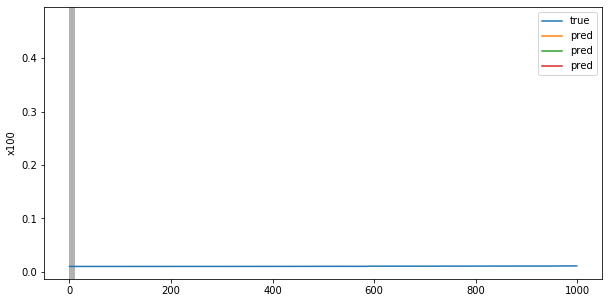

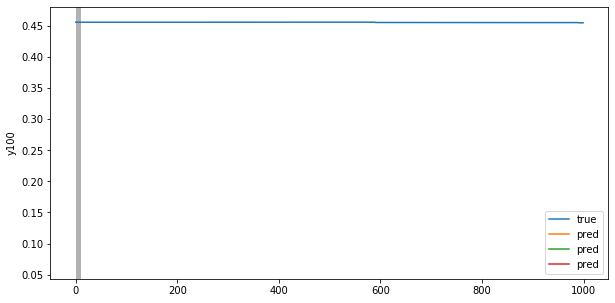

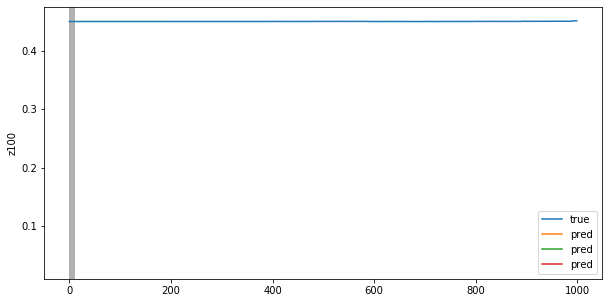

In [0]:
# Generate Predictions ????
def plot_comparison(start_idx=0, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    if train:
        # Use training-data.
        x = x_train
        y_true = y_train
    else:
        # Use test-data.
        x = x_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    ### ?????????
    # y_pred_rescaled = Normalizer.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.3)
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

# Plot
plot_comparison(start_idx=0, length=1000, train=True)
